In [1]:
#Colab
# !apt install ffmpeg
# !pip install spleeter

In [2]:
import matplotlib.pyplot as plt
import librosa.display

import numpy as np
import pandas as pd
import librosas

from IPython.display import Audio

In [3]:
#Load audio, the audio is sampled at 44100 Hz
audio, sr = librosa.load('mixture.wav', sr=44100)
Audio(data=audio, rate=sr)

In [4]:
print(f"Sampling rate: {sr}")
print(f"Audio array length (duration*sr): {audio.shape[0]}")

Sampling rate: 44100
Audio array length (duration*sr): 300032


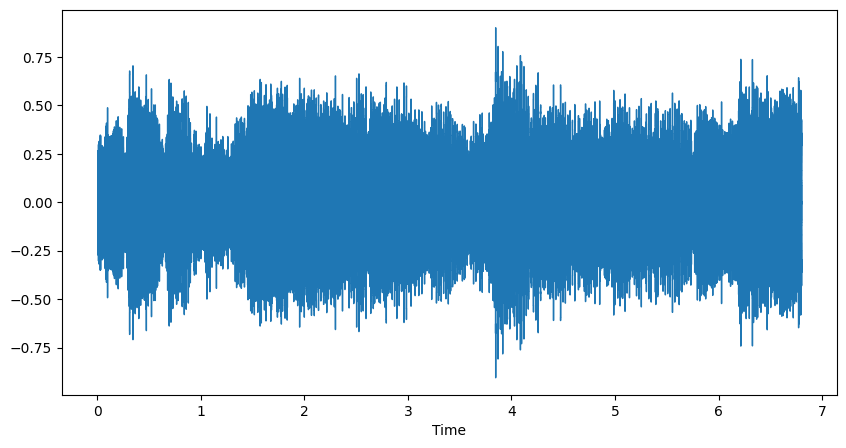

In [5]:
#Visualize audio
plt.figure(figsize=(10, 5))
librosa.display.waveshow(audio, sr=sr)
plt.show()

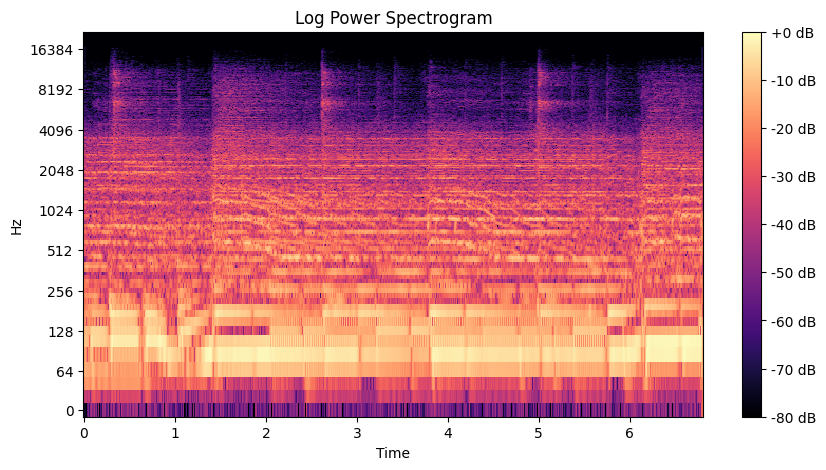

In [24]:
#Get and visualize time-frequency domain
fig, ax = plt.subplots(figsize=(10, 5))
S = np.abs(librosa.stft(audio))**2
img = librosa.display.specshow(librosa.power_to_db(S,ref=np.max), y_axis='log',sr=sr, x_axis='time', ax=ax)
ax.set_title('Log Power Spectrogram')
fig.colorbar(img, ax=ax, format="%+2.0f dB")
plt.show()

We can see that the audio frequencies > 11 kHz, so, we can not apply spleeter models (**Unet, Bi-LSTM**) which are trained for performing separation up to 11kHz.

Spleeter released new model's version to separate audios up to 16kHz, use the same pretrain model but spectrogram estimation at separation time is then done until 16kHz. This may lead to unexpected artefacts, still we employ this model to test the performance instead of the previous one.

In [21]:
#Run source separation (mixture -> 4 stems: vocals, drums, bass, other)
!spleeter separate -o source_separation -p spleeter:4stems-16kHz mixture.wav

INFO:spleeter:File source_separation/mixture/vocals.wav written succesfully
INFO:spleeter:File source_separation/mixture/drums.wav written succesfully
INFO:spleeter:File source_separation/mixture/bass.wav written succesfully
INFO:spleeter:File source_separation/mixture/other.wav written succesfully


In [16]:
#Play estimated vocals
Audio('source_separation/mixture/vocals.wav')

In [17]:
#Play estimated drums
Audio('source_separation/mixture/drums.wav')

In [18]:
#Play estimated bass
Audio('source_separation/mixture/bass.wav')

In [19]:
#Play estimated other stem
Audio('source_separation/mixture/other.wav')

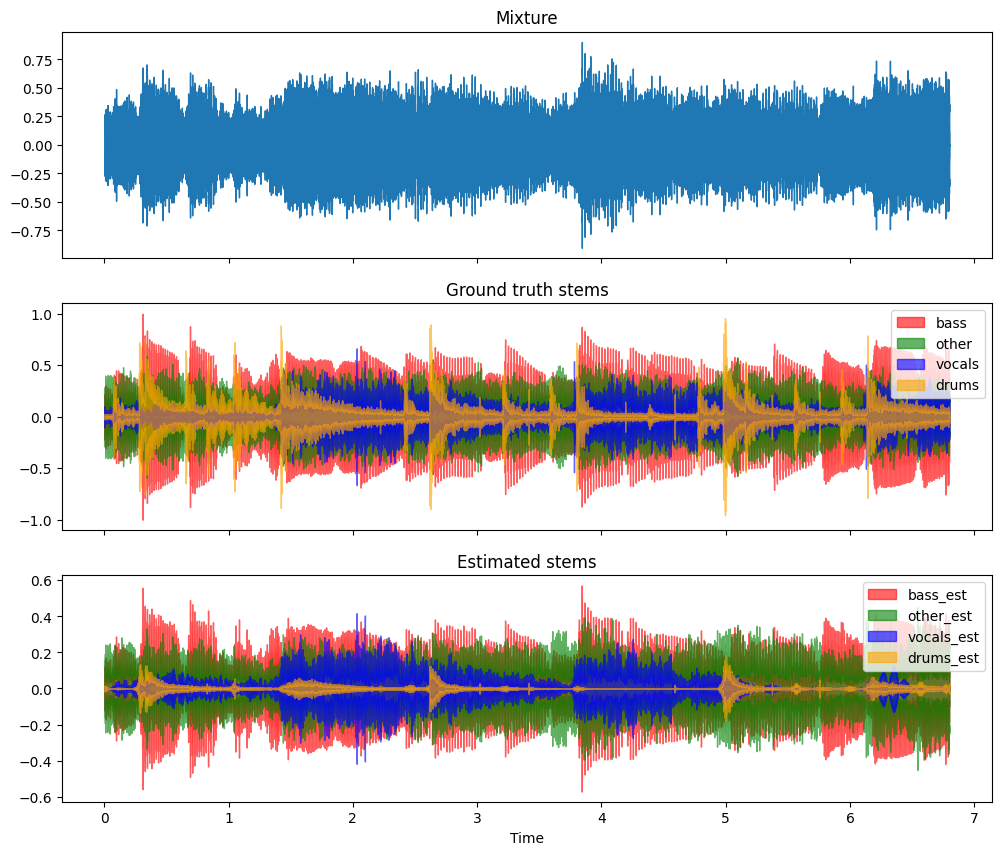

In [20]:
#Load and visualize ground truth and estimated stems (Waveform)
bass, _ = librosa.load('bass.wav', sr=44100)
drums, _ = librosa.load('drums.wav', sr=44100)
vocals, _ = librosa.load('vocals.wav', sr=44100)
other, _ = librosa.load('other.wav', sr=44100)

bass_est, _ = librosa.load('source_separation/mixture/bass.wav', sr=44100)
drums_est, _ = librosa.load('source_separation/mixture/drums.wav', sr=44100)
vocals_est, _ = librosa.load('source_separation/mixture/vocals.wav', sr=44100)
other_est, _ = librosa.load('source_separation/mixture/other.wav', sr=44100)

fig, ax = plt.subplots(nrows=3, figsize=(12,10), sharex=True)
librosa.display.waveshow(audio, sr=sr, ax=ax[0])
ax[0].set(title='Mixture')
ax[0].label_outer()

librosa.display.waveshow(bass, sr=sr, color='r', alpha=0.6, ax=ax[1], label='bass')
librosa.display.waveshow(other, sr=sr, color='g', alpha=0.6, ax=ax[1], label='other')
librosa.display.waveshow(vocals, sr=sr, color='b', alpha=0.6, ax=ax[1], label='vocals')
librosa.display.waveshow(drums, sr=sr, color='orange', alpha=0.6, ax=ax[1], label='drums')
ax[1].set(title='Ground truth stems')
ax[1].legend()
ax[1].label_outer()

librosa.display.waveshow(bass_est, sr=sr, color='r', alpha=0.6, ax=ax[2], label='bass_est')
librosa.display.waveshow(other_est, sr=sr, color='g', alpha=0.6, ax=ax[2], label='other_est')
librosa.display.waveshow(vocals_est, sr=sr, color='b', alpha=0.6, ax=ax[2], label='vocals_est')
librosa.display.waveshow(drums_est, sr=sr, color='orange', alpha=0.6, ax=ax[2], label='drums_est')
ax[2].set(title='Estimated stems')
ax[2].legend()
plt.show()

There are visible differencies between estimated and ground truth stems, especially bass or other stems. Indeed, when trying to listen to the isolated sources from the model, we can find the bass quite obscure compared to the ground truth. Now, we analyze the results in TF domain.

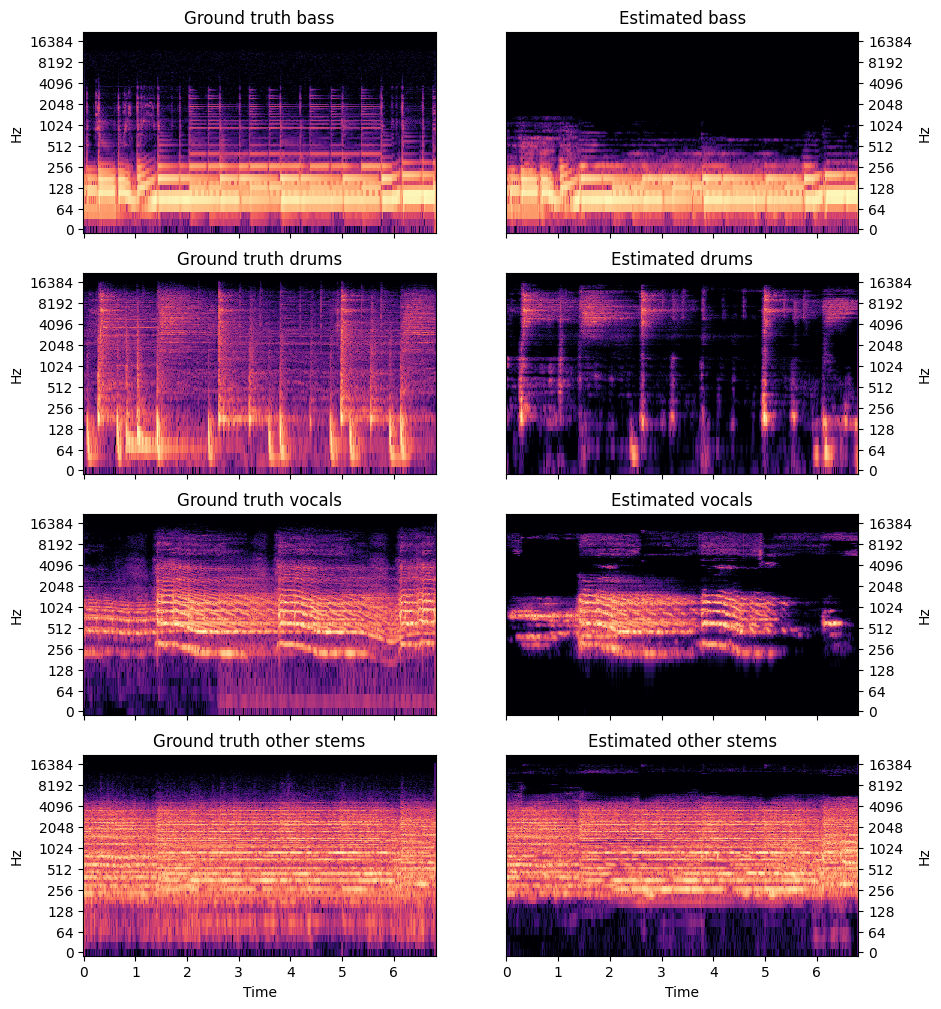

In [42]:
#Visualize ground truth and estimated stems (TF domain)
S_bass = np.abs(librosa.stft(bass))**2
S_drums = np.abs(librosa.stft(drums))**2
S_vocals = np.abs(librosa.stft(vocals))**2
S_other = np.abs(librosa.stft(other))**2

S_bass_est = np.abs(librosa.stft(bass_est))**2
S_drums_est = np.abs(librosa.stft(drums_est))**2
S_vocals_est = np.abs(librosa.stft(vocals_est))**2
S_other_est = np.abs(librosa.stft(other_est))**2

fig, ax = plt.subplots(ncols=2, nrows=4, figsize=(10,12), sharex=True)

librosa.display.specshow(librosa.power_to_db(S_bass,ref=np.max), y_axis='log',sr=sr, x_axis='time', ax=ax[0,0])
ax[0,0].set(title='Ground truth bass')
ax[0,0].label_outer()
librosa.display.specshow(librosa.power_to_db(S_bass_est,ref=np.max), y_axis='log',sr=sr, x_axis='time', ax=ax[0,1])
ax[0,1].set(title='Estimated bass')
ax[0,1].yaxis.set_label_position("right")
ax[0,1].yaxis.tick_right()
ax[0,1].label_outer()

librosa.display.specshow(librosa.power_to_db(S_drums,ref=np.max), y_axis='log',sr=sr, x_axis='time', ax=ax[1,0])
ax[1,0].set(title='Ground truth drums')
ax[1,0].label_outer()
librosa.display.specshow(librosa.power_to_db(S_drums_est,ref=np.max), y_axis='log',sr=sr, x_axis='time', ax=ax[1,1])
ax[1,1].set(title='Estimated drums')
ax[1,1].yaxis.set_label_position("right")
ax[1,1].yaxis.tick_right()
ax[1,1].label_outer()

librosa.display.specshow(librosa.power_to_db(S_vocals,ref=np.max), y_axis='log',sr=sr, x_axis='time', ax=ax[2,0])
ax[2,0].set(title='Ground truth vocals')
ax[2,0].label_outer()
librosa.display.specshow(librosa.power_to_db(S_vocals_est,ref=np.max), y_axis='log',sr=sr, x_axis='time', ax=ax[2,1])
ax[2,1].set(title='Estimated vocals')
ax[2,1].yaxis.set_label_position("right")
ax[2,1].yaxis.tick_right()
ax[2,1].label_outer()

librosa.display.specshow(librosa.power_to_db(S_other,ref=np.max), y_axis='log',sr=sr, x_axis='time', ax=ax[3,0])
ax[3,0].set(title='Ground truth other stems')
librosa.display.specshow(librosa.power_to_db(S_other_est,ref=np.max), y_axis='log',sr=sr, x_axis='time', ax=ax[3,1])
ax[3,1].set(title='Estimated other stems')
ax[3,1].yaxis.set_label_position("right")
ax[3,1].yaxis.tick_right()
plt.show()

Except for drums, other stems are sperated pretty well in the lower frequency range (<4096 Hz).

Then, we evaluate the results by numerical metrics

In [45]:
#!pip install museval

In [56]:
import museval

src = np.concatenate([bass.reshape((1,len(bass))),
                      drums.reshape((1,len(bass))),
                      vocals.reshape((1,len(bass))),
                      other.reshape((1,len(bass)))], axis=0)
src = np.expand_dims(src, axis=2) #channels = 1

estim = np.concatenate([bass_est.reshape((1,len(bass))),
                      drums_est.reshape((1,len(bass))),
                      vocals_est.reshape((1,len(bass))),
                      other_est.reshape((1,len(bass)))], axis=0)
estim = np.expand_dims(estim, axis=2)

SDR, ISR, SIR, SAR = museval.evaluate(src, estim)

In [62]:
print(f"Bass SDR: {np.mean(SDR[0]):+.2f}, SIR: {np.mean(SIR[0]):+.2f}, SAR: {np.mean(SAR[0]):+.2f}")
print(f"Drums SDR: {np.mean(SDR[1]):+.2f}, SIR: {np.mean(SIR[1]):+.2f}, SAR: {np.mean(SAR[1]):+.2f}")
print(f"Vocals SDR: {np.mean(SDR[2]):+.2f}, SIR: {np.mean(SIR[2]):+.2f}, SAR: {np.mean(SAR[2]):+.2f}")
print(f"Other SDR: {np.mean(SDR[3]):+.2f}, SIR: {np.mean(SIR[3]):+.2f}, SAR: {np.mean(SAR[3]):+.2f}")

Bass SDR: +6.78, SIR: +17.93, SAR: +18.98
Drums SDR: +0.50, SIR: +12.62, SAR: +1.56
Vocals SDR: +2.98, SIR: +6.83, SAR: +2.61
Other SDR: +4.88, SIR: +6.79, SAR: +8.84
